## <center> **Benchmarking Regression Algorithms on Diamond Price Data**
### <center> **by Trent Rivers** <br>CSPB 4622 - Machine Learning <br> Github: <br> https://github.com/cu-cspb-4622-summer-2025/P1-trentbrivers#

#### **Introduction**
The objective of this project is to explore applications of supervised machine learning, where a dataset that has been pre-labeled by humans is used to train a model for a given task. Historically, there are a number of different tasks where supervised learning models are typically used, including regression, classification, and multi-class classification. 
    
Thusfar, our coursework has largely focused on classification tasks; however, many supervised learning models that are often used for classification can also be used for regression. While the usefulness of classifications is evident, there are other problems where accurately predicting numerical values is necessary, such as predicting prices. When goods have many unique attributes that relate to each other in complex, unintuitive ways to define their final price on the market, supervised machine learning can be used to model these relationships and predict prices based on features.

In this project, the focus will be on predicting the prices of diamonds. Diamonds are an expensive good, and a casual observer may not be able to discern what differentiates a $5,000 diamond from a $2,000 diamond. There are many features that contribute to a diamond's price, including its clarity, cut, dimensions, and more, and machine learning will be used to model the interrelation of these features as they contribute to the price of a diamond. The models to be tested include a Multilinear Regression, K-Nearest Neighbors, Decision Tree, and an AdaBoost Regressor. These models will be implemented using SciKit Learn.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm

#### **The Dataset**

The dataset used for this project will be the "diamonds" dataset found on kaggle at https://www.kaggle.com/datasets/resulcaliskan/diamonds/data. 

This dataset is a CSV file that consists of 53,940 samples, where each sample represents a single diamond.  

The following is a description of the features included in the data for each diamond:
* **Carat**: a unit of measurement for precious stones, equivalent to 200 milligrams
* **Cut**: the diamond's cut grade, from best to worst in Ideal, Premium, Very Good, Good, Fair, and Poor
* **Color**: color of a diamond, recorded alphabetically, with values from D to F representing the most colorless and most rare and valuable diamonds, and values from N to Z representing diamonds with a yellow or brown tint which are more common and less expensive
* **Clarity**: whether the diamond contains inclusions (internal and surface reaching anomalies) or blemishes on its exterior; values are on a scale from best to worst - Flawless, Internally Flawless ('IF'), Very Very Slightly Included ('VVS1' and 'VVS2'), Very Slightly Included ('VS1' and 'VS2'), Slightly Included ('SI1' and 'SI2'), and Included ('I1', 'I2', and 'I3') note: lower numbers are always preferable 
* **Depth**: the distance from table (top) to bottom (cutlet); measured as a percentage
* **Table**: the width of the top surface of the diamond; measured as a percentage
* **Width**, **Length**, and **Height** measured in millimeters
* **Price**: the price in dollars (the target column)

In [ ]:
diamond_df = pd.read_csv("diamonds.csv")
diamond_df = diamond_df.rename(columns = {'x': 'width', 'y': 'length', 'z': 'height'})
diamond_df.head(5)

,carat,cut,color,clarity,depth,table,width,length,height,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


### **Exploratory Data Analysis and Data Preparation**

In [ ]:
diamond_df.describe()

,carat,depth,table,width,length,height,price
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,5.731157,5.734526,3.538734,3932.799722
std,0.474011,1.432621,2.234491,1.121761,1.142135,0.705699,3989.439738
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,950.000000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,2401.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,5324.250000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,18823.000000


#### Correcting the Dimension Data

The table above includes some summary statistics for the dataset and each column within it. Having 53,940 samples should be sufficient to adequately train and test any desired model architecture. However, what we can observe thusfar is that a couple of things ought to happen with this dataset. Firstly, some samples the dataset appear suspect due to their width, length, and height values (a diamond can not exist with no dimensions). Additionally, comparing the maximum values to the 75th percentiles, especially on length and height, is another indicator that some data may need to be removed.

In [ ]:
print("zero width: ", diamond_df[diamond_df["width"] == 0].shape[0])
print("zero length: ", diamond_df[diamond_df["length"] == 0].shape[0])
print("zero height: ", diamond_df[diamond_df["height"] == 0].shape[0])

zero width:  8
zero length:  7
zero height:  20


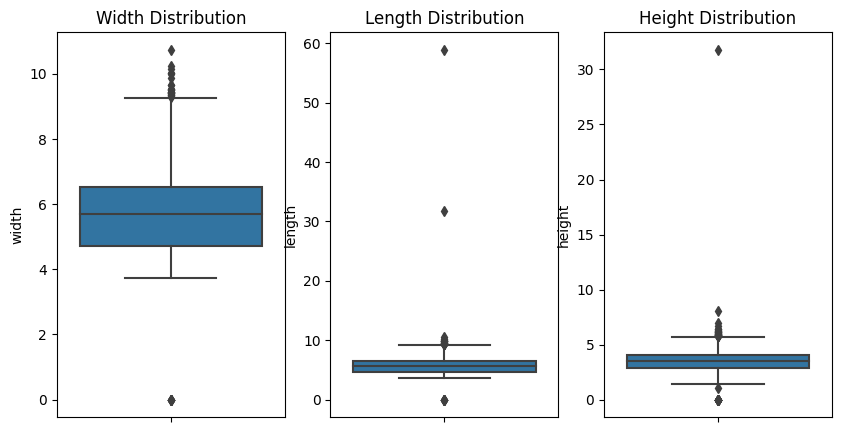

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.boxplot(data = diamond_df, y = "width", ax = axes[0])
axes[0].set_title("Width Distribution")
sns.boxplot(data = diamond_df, y = "length", ax = axes[1])
axes[1].set_title("Length Distribution")
sns.boxplot(data = diamond_df, y = "height", ax = axes[2])
axes[2].set_title("Height Distribution")

plt.show()

In [ ]:
q_val_upper = 0.9995
q_val_lower = 0.0005
print("height ", q_val_upper *100, "th quantile: ", diamond_df["length"].quantile(q_val_upper))
print("height ", q_val_lower *100, "th quantile: ", diamond_df["length"].quantile(q_val_lower))
print("length ", q_val_upper *100, "th quantile: ", diamond_df["height"].quantile(q_val_upper))
print("height ", q_val_lower *100, "th quantile: ", diamond_df["height"].quantile(q_val_lower))

height  99.95 th quantile:  9.141525000000039
height  0.05 th quantile:  3.84
length  99.95 th quantile:  5.750305000000008
height  0.05 th quantile:  2.269695


The plots above indicate that some extreme values do exist within the dataset. While the width values across the dataset appear more even in distribution, length and height have some significant outliers that skew the distribution of the dataset. Investigating the top and bottom 0.0005% of the dataset reveals that the extremes observed in the plots fall significantly outside of where the other 99.9% of the data falls. These outliers ought to be removed since they deviate so much from the rest of the dataset and appear erroneous. 

In [ ]:
#Remove length extremes
diamond_df = diamond_df[diamond_df['length'] > diamond_df['length'].quantile(q_val_lower)]
diamond_df = diamond_df[diamond_df['length'] < diamond_df['length'].quantile(q_val_upper)]
#Remove height extremes
diamond_df = diamond_df[diamond_df['height'] > diamond_df['height'].quantile(q_val_lower)]
diamond_df = diamond_df[diamond_df['height'] < diamond_df['height'].quantile(q_val_upper)]

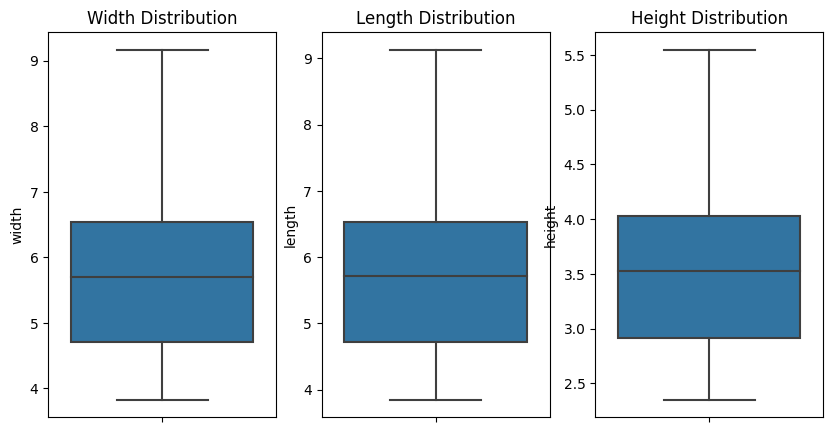

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.boxplot(data = diamond_df, y = "width", ax = axes[0])
axes[0].set_title("Width Distribution")
sns.boxplot(data = diamond_df, y = "length", ax = axes[1])
axes[1].set_title("Length Distribution")
sns.boxplot(data = diamond_df, y = "height", ax = axes[2])
axes[2].set_title("Height Distribution")

plt.show()

In [ ]:
print(diamond_df.shape[0])

53828


After removing the most extreme 0.1% of the upper and lower extremes from the length and height, the distributions of values within the dataset are less skewed.

#### One Hot Encoding Qualitative Columns

There are three columns present in the dataset where the features, in their current form, can not be used to train regression models. These include Cut, Color, and Clarity, which are recorded in the data as qualitative classifications and not numerical values. To address this, these columns will be one-hot encoded to make them usable by regression models. 

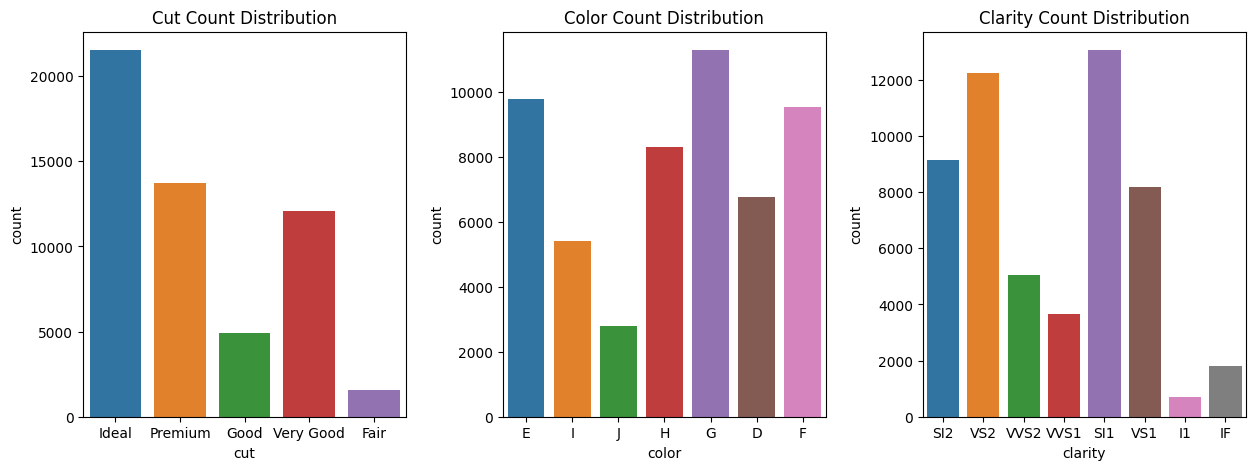

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.countplot(data = diamond_df, x = "cut", ax = axes[0])
axes[0].set_title("Cut Count Distribution")
sns.countplot(data = diamond_df, x = "color", ax = axes[1])
axes[1].set_title("Color Count Distribution")
sns.countplot(data = diamond_df, x = "clarity", ax = axes[2])
axes[2].set_title("Clarity Count Distribution")
plt.subplots_adjust(wspace=0.3) # Adjust wspace for horizontal spacing

plt.show()

In [ ]:
print(diamond_df['cut'].unique())
print(diamond_df['color'].unique())
print(diamond_df['clarity'].unique())

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'G' 'D' 'F']
['SI2' 'VS2' 'VVS2' 'VVS1' 'SI1' 'VS1' 'I1' 'IF']


Based on what we can see here, the new one-hot encoded dataframe should have a total of 5 additional columns for cut types, 7 additional columns for color variations, and 8 additional columns for clarity classifications. 

In [ ]:
def ohe_feature(data, feature):
    """
    Takes two arguments: a dataframe and a feature name (string)
    The feature is one-hot encoded into new columns and the original is dropped.
    """
    data_copy = data.copy()
    funky_ohe = OneHotEncoder()
    funky_ohe.fit([[x] for x in data_copy[feature].unique()]);
    
    test = [[x] for x in data_copy[feature]]
    test2 = funky_ohe.transform(test).toarray()
    
    names = funky_ohe.get_feature_names_out([feature])
    for i in range(len(names)):
        data_copy[names[i]] = [x[i] for x in test2]
    
    data_copy = data_copy.drop(labels = [feature], axis = 1)
    return data_copy

feature_encode = ['cut', 'color', 'clarity']
for f in feature_encode:
    diamond_df = ohe_feature(diamond_df, f)

diamond_df.head(5)

,carat,depth,table,width,length,height,price,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,326,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.29,62.4,58.0,4.20,4.23,2.63,334,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,63.3,58.0,4.34,4.35,2.75,335,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.24,62.8,57.0,3.94,3.96,2.48,336,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.24,62.3,57.0,3.95,3.98,2.47,336,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Understanding the Distribution of Prices

The goal of this project is to test the comparative performance of different regressor models in predicting diamond prices. To that end, it is useful to first visualize the distribution of prices within the dataset to gain a better understanding of the data in use.

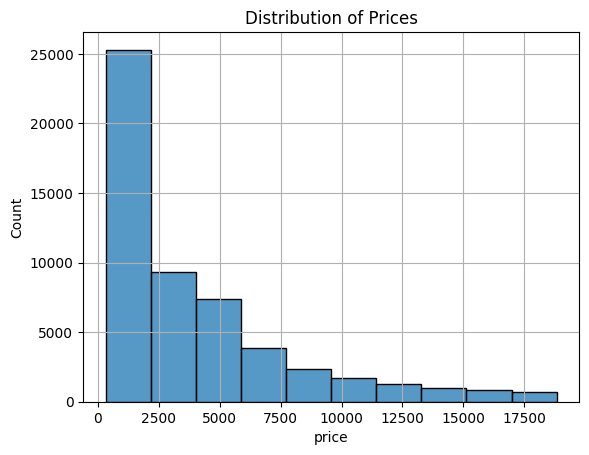

In [ ]:
sns.histplot(data = diamond_df, x = "price", bins = 10)
plt.title("Distribution of Prices")
plt.grid(True)
plt.show()

What can be observed above is that, of the cleaned dataset of 53828 samples, nearly half are in the <$2500 range. Looking towards the right of the histogram, the values at the upper end of the price distribution are each represented by <10% of the dataset across each bin. Given the skew seen in this distribution, the ability of any regressor to accurately predict prices at the upper end of the distribution may be limited due to the relative lack of samples at that price range. 

#### What features are likely to have the greatest impact?

Below, we can see which features are most strongly correlated with the price of a diamond. It ought not be surprising that the size and weight of a diamond are the features that most closely correlate with the price. It is predictable that the one-hot encoded features would each have little individual correlation with the price; however, as this project progresses, whether the larger features they are derived from, including cut, color, and clarity, are useful predictors will need to be determined. 

In [ ]:
correlation_mat = diamond_df.corr()
print(correlation_mat['price'].sort_values(ascending=False)[1:])

carat            0.923753
length           0.888453
width            0.886839
height           0.882329
table            0.127231
clarity_SI2      0.126466
cut_Premium      0.095780
color_I          0.095361
color_J          0.079765
color_H          0.058337
cut_Fair         0.014785
clarity_SI1      0.010167
color_G          0.009100
cut_Very Good    0.007479
clarity_VS2      0.000745
cut_Good        -0.000779
clarity_VS1     -0.008833
clarity_I1      -0.009859
depth           -0.013457
color_F         -0.023079
clarity_IF      -0.049363
clarity_VVS2    -0.051778
color_D         -0.071848
clarity_VVS1    -0.095167
cut_Ideal       -0.096267
color_E         -0.099823
Name: price, dtype: float64


#### Final Data Preparation

It's time to split the data into separate training and testing sets. Sci-kit learn's train_test_split function will be used to do this. 

In [ ]:
feature_set = diamond_df.drop(columns = "price", axis = 1)
price_target = diamond_df['price']

X_train, X_test, y_train, y_test = train_test_split(feature_set, price_target, test_size = 0.10)
print(X_train.shape[0], X_test.shape[0])

48445 5383


## **Regression Modeling**

Now that the data has been explored, the time has come to begin training regressors. The models that will follow include a Multi-Linear Regression model, a K-Nearest Neighbors Regressor, a Decision Tree Regressor, and an AdaBoost Regressor. The basis for using the aforementioned models is this: 
* Linear Regression is one of the most standard and commonplace regression techniques. A Multiple Linear Regression introduces additional features, which will be components of all of the other models tested in this project. The Multiple Linear Regression will be the standard to compare performance against across this project.
* K-Nearest Neighbors operates on an extraordinarily simple algorithm, allowing models using it to train at a remarkable rate. As a non-parametric model (unlike Multiple Linear Regression), it would be wortwhile to include due to its speed and accuracy in many use cases. 
* Decision Trees are another non-parametric model, like K-Nearest Neighbors. However, the underlying architecture is more complex, using data features to construct a unique chain of decision points that allow it to classify or predict values. While it is a non-parametric model, Decision Trees have a number of hyperparameters to tune to further boost performance. Decision Trees offer another contrasting approach to Supervised Learning, and their tuning potential and relative complexity make them useful to compare against. 
* AdaBoost is a tree ensembling algorithm, built on top of smaller Decision Trees. AdaBoost is meant to combat over-fitting (a common problem with Decision Trees), so it would be useful to verify if it can further improve regression performance beyond that of an individual Decision Tree. 

To offer a standard point of comparison among models,  a residual plot, the R2 Score, and the Root Mean Squared Error of each model will be provided at the end of each section.

### Multiple Linear Regression

Linear Regression is likely the most common algorithm used for regression tasks. In simple linear regression, a single feature is used to fit a linear function to a target. Multiple linear regression is more complicated in that the introduction of additional features leads to the creation of a more complex, non-linear function that may fit the data better. 

Unlike other models, Linear Regression contains no hyperparameters - the only modification to improve performance is the inclusion or exclusion of features. To begin, it would be wortwhile to establish a baseline of performance using all available features. 

In [220]:
base_lr = LinearRegression()
base_lr.fit(X_train, y_train)
base_lr_preds = base_lr.predict(X_test)
base_lr_rmse = np.sqrt(mean_squared_error(y_test, base_lr_preds))
base_lr_r2 = r2_score(y_test, base_lr_preds)
print("rmse: ", base_lr_rmse, "R2: ", base_lr_r2)

rmse:  1108.0666310142442 R2:  0.9238182356282308


#### Regression Improvement through Feature Selection

While Linear Regression is a non-parametric model, the features included in the regression do impact performance. With that in mind, the removal or inclusion of certain features could improve performance beyond the baseline established above, which uses all available features. 

The code below uses a hybrid, foward and backward selection technique to include useful features from the dataset and ignore those features which contribute nothing. 

In [221]:
special_train_copy = X_train.assign(price =y_train)
special_train_copy = special_train_copy.rename(columns = {'cut_Very Good': 'cut_Very_Good'})
base_formula = "price ~ "
possible_features = list(special_train_copy.drop(columns = ['price']).columns)
best_model = 0
p_val_threshold = 0.005

feature_list = []
    
while(1):
    #Part 1: best feature (highest adj r2)
    features_by_r2 = []
    for feature in possible_features:
        current_formula = base_formula + "+".join(feature_list) +"+"+ feature
        mod = smf.ols(formula=current_formula, data=special_train_copy)
        res = mod.fit()    
        features_by_r2.append([feature, res.rsquared_adj])

    possible_features = [x[0] for x in sorted(features_by_r2, key = lambda y: -y[1])]
    feature_list.append(possible_features.pop(0))

    #Part 2: Remove high p-values
    current_formula = base_formula + "+".join(feature_list)
    mod = smf.ols(formula=current_formula, data=special_train_copy)
    res = mod.fit()   
    best_model = res.rsquared_adj

    features_changed = feature_list

    pvals = res.pvalues
    worst_feature = pvals[pvals == pvals.max()].index[0]
    if (pvals.max() > p_val_threshold) and (worst_feature != 'Intercept'):
        features_changed.remove(worst_feature)
        if feature_list == features_changed:
            break


current_formula = base_formula + "+".join(feature_list)
mod = smf.ols(formula=current_formula, data=special_train_copy)
res = mod.fit()


#### 'Trimmed' Feature Set Results

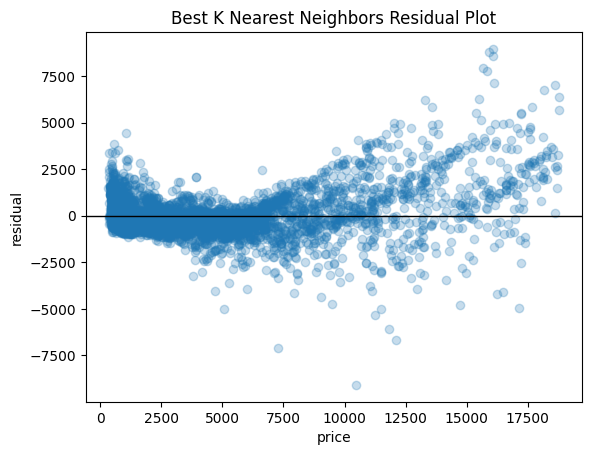

In [222]:
special_test_copy = X_test.assign(price =y_test)
special_test_copy = special_test_copy.rename(columns = {'cut_Very Good': 'cut_Very_Good'})
adjusted_preds = res.predict(special_test_copy)

adjusted_lr_residuals = y_test - adjusted_preds

plt.scatter(y_test, adjusted_lr_residuals, alpha = 0.25)
plt.axhline(0, c='black', linewidth = 1)
plt.title("Best K Nearest Neighbors Residual Plot")
plt.xlabel("price")
plt.ylabel("residual")
plt.show()


In [223]:
adjusted_lr_rmse = np.sqrt(mean_squared_error(y_test, adjusted_preds))
adjusted_lr_r2 = r2_score(y_test, adjusted_preds)
print("New number of features:", len(feature_list))
print("Best Multilinear Regression RMSE: ", adjusted_lr_rmse)
print("Best Multilinear Regression R2 Score: ", adjusted_lr_r2)

New number of features: 21
Best Multilinear Regression RMSE:  1107.9777919781325
Best Multilinear Regression R2 Score:  0.9238304508561216


Surprisingly, going through the feature selection process did virtually nothing either positively or negatively to the performance of the original Multilinear Regression model.

### K-Nearest Neighbors Regression

Unsurprisingly, the logic of a K-Nearest Neighbors Regressor is similar to a K-Nearest Neighbors Classifier - "The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set." [1]. Under normal circumstances, the only hyperparameter present in this model is K, the number of neighbors to evaluate to determine the label of the current data point. However, the Sci-Kit Learn regressor has a weight function which can be used in prediction, with 'uniform' assigning a uniform weighting to all neighbors, while 'distance' increases the influence of closer neighbors of a query point. 

To begin, all hyperparameters, including the number of neighbors and weight function, will be left to their defaults. 

In [261]:
#The default regressor uses k = 5 neighbors and uniform weighting to nearest neighbors.
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)

KNeighborsRegressor()

In [262]:
knr_preds = knr.predict(X_test)
knr_rmse = np.sqrt(mean_squared_error(y_test, knr_preds))
knr_r2 = r2_score(y_test, knr_preds)
print("rmse: ", knr_rmse, "R2: ", knr_r2)

rmse:  942.7100317768092 R2:  0.9448588866058357


The R2 value seen above is a baseline for improving performance through a bit of tuning. 

#### Hyperparameter Optimization
The hyperparameters to be explored include k, the number of neighbors used in interpolation, and the Sci-Kit Learn 'weight' function, which can be either 'uniform' (default) or 'distance'. 

In [263]:
r2_uniform = []
r2_distance = []
val_range = np.arange(1, 51)
for v in val_range:
    knr_uni = KNeighborsRegressor(n_neighbors = v, weights = 'uniform')
    knr_uni.fit(X_train, y_train)
    uni_preds = knr_uni.predict(X_test)
    r2_uniform.append(r2_score(y_test, uni_preds))
                      
    knr_dist = KNeighborsRegressor(n_neighbors = v, weights = 'distance')
    knr_dist.fit(X_train, y_train)
    dist_preds = knr_dist.predict(X_test)
    r2_distance.append(r2_score(y_test, dist_preds))


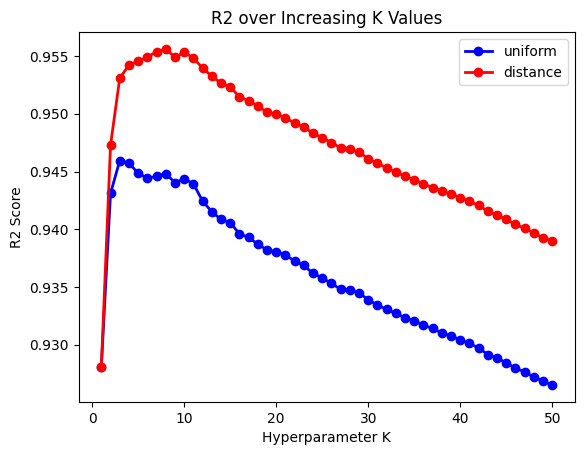

In [264]:
plt.plot(val_range, r2_uniform, marker = 'o', color = 'blue', lw = 2, label = 'uniform')
plt.plot(val_range, r2_distance, marker = 'o', color = 'red', lw = 2, label = 'distance')
plt.xlabel("Hyperparameter K")
plt.ylabel("R2 Score")
plt.title("R2 over Increasing K Values")
plt.legend()
plt.show()

In [265]:
df = pd.DataFrame({'K Values': val_range, 'R2 Uniform': r2_uniform, 'R2 Distance': r2_distance})
print(max(r2_distance))
df.head(10)

0.9556113694720249


,K Values,R2 Uniform,R2 Distance
0,1,0.928077,0.928077
1,2,0.943104,0.947286
2,3,0.945936,0.953068
3,4,0.945722,0.954218
4,5,0.944859,0.954547
5,6,0.944434,0.954907
6,7,0.944574,0.955369
7,8,0.944826,0.955611
8,9,0.944027,0.954898
9,10,0.944361,0.955305


We can observe above that a K-Nearest Neighbors Regressor with a distance weighting function consistently exceeded the performance of the uniform weighting function. In multiple tests, it has been observed (and what can be seen above) is that k values from 5 to 8 produce the best results. Values up to k = 50 nearest neighbors were tested; however, given the downward trends of the lines in the above plot, it is reasonable to conclude that continuing to test increasing values of k will provide no benefit. 

#### Tuned Results

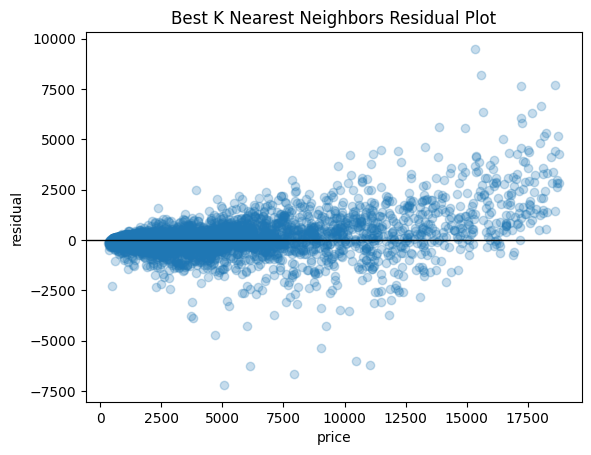

In [266]:
best_knr = KNeighborsRegressor(n_neighbors = val_range[np.argmax(r2_distance)], weights = 'distance')
best_knr.fit(X_train, y_train)
best_knr_preds = best_knr.predict(X_test)

best_knr_residuals = y_test - best_knr_preds

plt.scatter(y_test, best_knr_residuals, alpha = 0.25)
plt.axhline(0, c='black', linewidth = 1)
plt.title("Best K Nearest Neighbors Residual Plot")
plt.xlabel("price")
plt.ylabel("residual")
plt.show()

In [267]:
best_knr_rmse = np.sqrt(mean_squared_error(y_test, best_knr_preds))
best_knr_r2 = r2_score(y_test, best_knr_preds)
print("Best K Nearest Neighbors RMSE: ", best_knr_rmse)
print("Best K Nearest Neighbors R2 Score: ", best_knr_r2)

Best K Nearest Neighbors RMSE:  845.8166622639077
Best K Nearest Neighbors R2 Score:  0.9556113694720249


### Decision Tree Regression

Decision Tree Regressors operate much the same as Decision Tree Classifiers in that they both learn simple decision rules from the data features [2]. While classifiers work with discretely defined values, a regressor will attempt to predict values on a continuous scale.

Before any hyperparameter tuning to maximize performance, it would be valuable to establish a baseline with a default classifier. 

In [231]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [232]:
dtr_preds = dtr.predict(X_test)
dtr_rmse = np.sqrt(mean_squared_error(y_test, dtr_preds))
dtr_score = r2_score(y_test, dtr_preds)
print("rmse: ", dtr_rmse, "r2: ", dtr_score)

rmse:  765.378903468111 r2:  0.9636526922177466


#### Further tuning - is it possible?

With an R2 score exceeding 0.96, there's only a small window in which to potentially improve performance further. Indeed, with the default hyperparameters, Sci-Kit Learn's default Decision Tree Regressor is performing exceptionally. Many of the hyperparameters one might adjust on a Decision Tree attempt to address the problem of overfitting. One of the most common problems encountered when using Decision Trees is overfitting. Considering the R2 score of the regressor on the training set (0.999995), the deviation between the test and train performance may be the result of some overfitting. 

In [233]:
dtr_trainp = dtr.predict(X_train)
print(r2_score(y_train, dtr_trainp))

0.9999963550518022


In [234]:
"""
criterion_values = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter_values = ['best', 'random']
max_depth_range = np.arange(5, 100, 5)
min_sample_split_range = np.arange(2, 5)
min_samples_leaf_range = np.arange(1, 5)
tree_param_results = []

for c in criterion_values:
    for s in splitter_values:
        for md in max_depth_range:
            for mss in min_sample_split_range:
                for msl in min_samples_leaf_range:
                    current_tree = DecisionTreeRegressor(criterion = c, splitter = s, max_depth = md, min_samples_split = mss, min_samples_leaf = msl)
                    current_tree.fit(X_train, y_train)
                    current_preds = current_tree.predict(X_test)
                    current_r2 = r2_score(y_test, current_preds)
                    tree_param_results.append([[c,s,md,mss,msl],current_r2])
"""
None

After attempting to test a broad range of hyperparameter combinations en masse (the code above), which failed to complete in a reasonable timeframe, more limited tests on individual hyperparameters have been undertaken below. The goal is to find better initial values and test combinations in a limited range. 

The hyperparameters to be tested include the following: 
* min_samples_leaf: the minimum number of samples to be at a leaf node (default 1)
* max_depth: limits the depth of the Decision Tree (default None)
* min_impurity_decrease: splits a node if the decrease of impurity is greater than or equal to this value (default 0.0)
* ccp_alpha: allows the tree to use minimal cost-complexity pruning to avoid over-fitting (default 0.0); read more here: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

leaf modification [14, 0.9761579129066045]


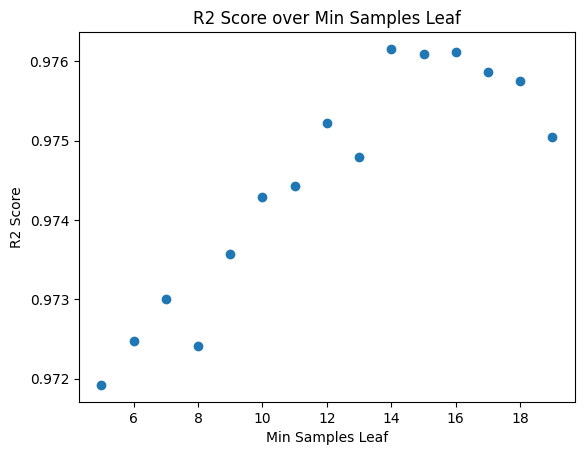

In [235]:
leaf_tests = np.arange(5, 20, 1)
leaf_res = []
for l in leaf_tests:
    leaf_dtr = DecisionTreeRegressor(min_samples_leaf = l)
    leaf_dtr.fit(X_train, y_train)
    leaf_preds = leaf_dtr.predict(X_test)
    leaf_res.append([l, r2_score(y_test, leaf_preds)])
best_leaf_val = max(leaf_res, key = lambda r: r[1])
print("leaf modification", best_leaf_val)

plt.scatter(x = [r[0] for r in leaf_res], y = [r[1] for r in leaf_res])
plt.xlabel("Min Samples Leaf")
plt.ylabel("R2 Score")
plt.title("R2 Score over Min Samples Leaf")
plt.show()

depth modification [13, 0.9717583747108557]


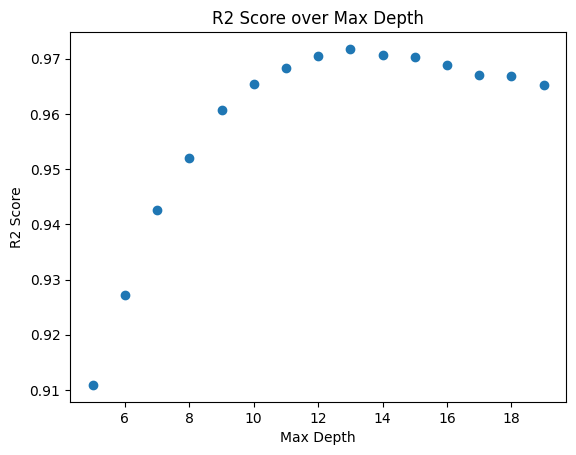

In [236]:
depth_tests = np.arange(5, 20, 1)
depth_res = []
for d in depth_tests:
    depth_dtr = DecisionTreeRegressor(max_depth = d)
    depth_dtr.fit(X_train, y_train)
    depth_preds = depth_dtr.predict(X_test)
    depth_res.append([d, r2_score(y_test, depth_preds)])

best_depth_val = max(depth_res, key = lambda r: r[1])
print("depth modification", best_depth_val)

plt.scatter(x = [r[0] for r in depth_res], y = [r[1] for r in depth_res])
plt.xlabel("Max Depth")
plt.ylabel("R2 Score")
plt.title("R2 Score over Max Depth")
plt.show()

min impurity modification [0.03, 0.964794254320565]


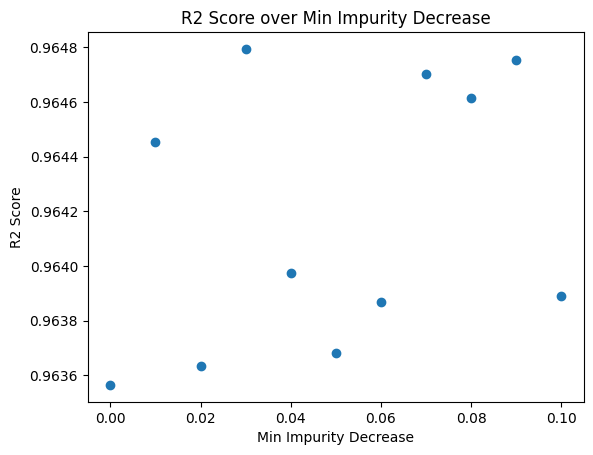

In [237]:
ip_tests = np.arange(0.0, 0.11, 0.01)
ip_res = []
for i in ip_tests:
    ip_dtr = DecisionTreeRegressor(min_impurity_decrease = i)
    ip_dtr.fit(X_train, y_train)
    ip_preds = ip_dtr.predict(X_test)
    ip_res.append([i, r2_score(y_test, ip_preds)])

best_ip_val = max(ip_res, key = lambda r: r[1])
print("min impurity modification", best_ip_val)

plt.scatter(x = [r[0] for r in ip_res], y = [r[1] for r in ip_res])
plt.xlabel("Min Impurity Decrease")
plt.ylabel("R2 Score")
plt.title("R2 Score over Min Impurity Decrease")
plt.show()

pruning added  [0.06, 0.9652262893538492]


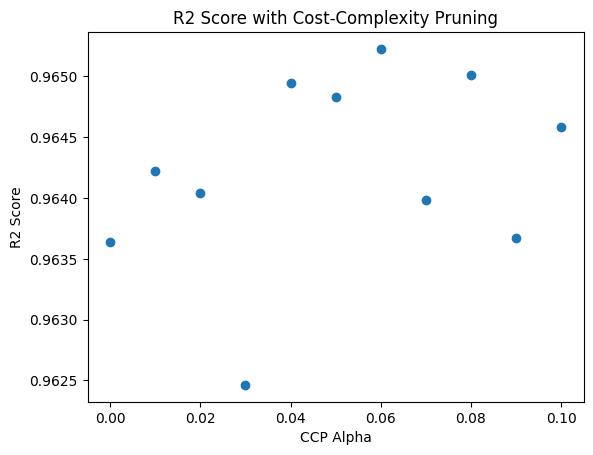

In [238]:
ccp_tests = np.arange(0.0, 0.11, 0.01)
ccp_res = []
for c in ccp_tests:
    ccp_dtr = DecisionTreeRegressor(ccp_alpha = c)
    ccp_dtr.fit(X_train, y_train)
    ccp_preds = ccp_dtr.predict(X_test)
    ccp_res.append([c, r2_score(y_test, ccp_preds)])

best_ccp_val = max(ccp_res, key = lambda r: r[1])
print("pruning added ", best_ccp_val)

plt.scatter(x = [r[0] for r in ccp_res], y = [r[1] for r in ccp_res])
plt.xlabel("CCP Alpha")
plt.ylabel("R2 Score")
plt.title("R2 Score with Cost-Complexity Pruning")
plt.show()

In [239]:
print("untuned score", dtr_score)
print("leaf modification", best_leaf_val)
print("depth modification", best_depth_val)
print("min impurity modification", best_ip_val)
print("pruning added ", best_ccp_val)

untuned score 0.9636526922177466
leaf modification [14, 0.9761579129066045]
depth modification [13, 0.9717583747108557]
min impurity modification [0.03, 0.964794254320565]
pruning added  [0.06, 0.9652262893538492]


#### Limited Tuning Analysis & Combination Testing

The two most impactful hyperparameters tested were min_samples_leaf and max_depth, both of which were able to meaningfully exceed the R2 score of the baseline Decision Tree at their best. At every value in the range tested, the tree with a modified min_samples_leaf was able to best the baseline R2 score, making it the most valuable hyperparameter to tune here. 

In modifying min_impurity_decrease and ccp_alpha, no discernible trends could be observed in the results, and even the best R2 scores from each were only a marginal increase (in the case of min_impurity_decrease) or a marginal decrease (for ccp_alpha) over the baseline Decision Tree. In repeated tests, results continued to vary, with no conclusive best value being produced for either. Given the inconsistency of results and the insignifcance of their impact on the R2 of the fitted trees, neither min_impurity_decrease or ccp_alpha will be included moving forward.

Hyperparameters are interdependent in how they influence a model, therefore different combinations of hyperparameter values in a limited range around the best values found above will be tested here. 

In [240]:
depth_range = np.arange(best_depth_val[0] -2, best_depth_val[0] + 4)
leaf_range = np.arange(best_leaf_val[0] - 2, best_leaf_val[0] + 4)
tune_res = []
for d in depth_range:
    for l in leaf_range:
        current_dt = DecisionTreeRegressor(max_depth = d, min_samples_leaf = l)
        current_dt.fit(X_train, y_train)
        current_preds = current_dt.predict(X_test)
        current_r2 = r2_score(y_test, current_preds)
        tune_res.append([[d, l], current_r2])

best_combo = max(tune_res, key = lambda r: r[1])
print("Best performance produced by ", best_combo[0][0], "max_depth, ", best_combo[0][1], "min_samples_leaf, producing an R2 score of ", best_combo[1])

Best performance produced by  16 max_depth,  16 min_samples_leaf, producing an R2 score of  0.9761130693374228


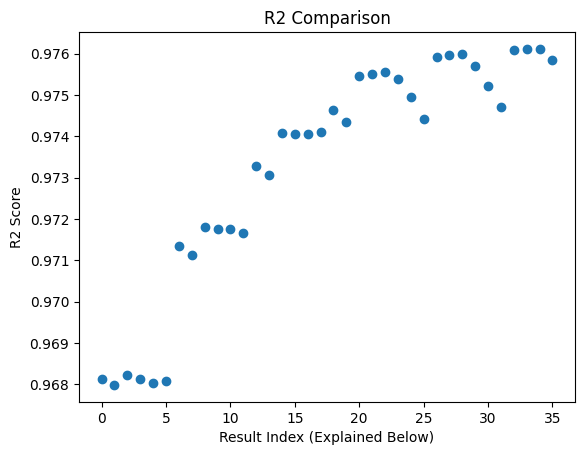

In [241]:
plt.scatter(x = range(len(tune_res)), y = [t[1] for t in tune_res])
plt.xlabel("Result Index (Explained Below)")
plt.ylabel("R2 Score")
plt.title("R2 Comparison")
plt.show()

While a better method of visualizing the result of the tuning combinations may exist, the above can be understood if you consider the structure of the code used to produce the R2 scores. A Decision Tree was trained with each iteration of a nested for loop. The outer loop would increment the value of max_depth, and the inner loop would increment the value of min_samples_leaf. The impact of this can be observed in the scatter plot, where points are loosely grouped around their max_depth value, with smaller variations for each value of min_samples_leaf in the inner loop. 

#### Tuned Results

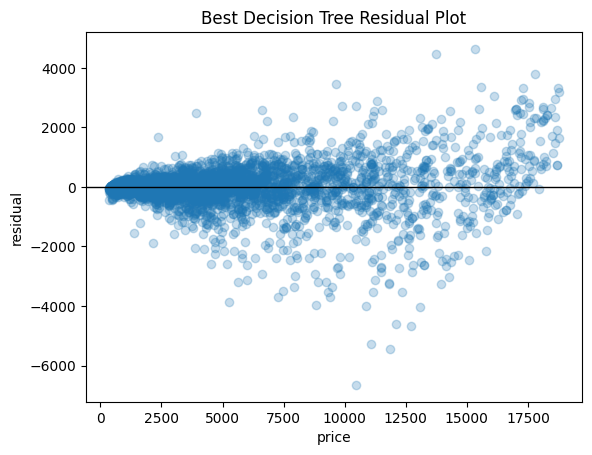

In [242]:
best_dt = DecisionTreeRegressor(max_depth = best_combo[0][0], min_samples_leaf = best_combo[0][1])
best_dt.fit(X_train, y_train)
best_dt_preds = best_dt.predict(X_test)

best_dt_residuals = y_test - best_dt_preds

plt.scatter(y_test, best_dt_residuals, alpha = 0.25)
plt.axhline(0, c='black', linewidth = 1)
plt.title("Best Decision Tree Residual Plot")
plt.xlabel("price")
plt.ylabel("residual")
plt.show()

In [243]:
best_dt_rmse = np.sqrt(mean_squared_error(y_test, best_dt_preds))
best_dt_r2 = r2_score(y_test, best_dt_preds)
print("Best Decision Tree RMSE: ", best_dt_rmse)
print("Best Decision Tree R2 Score: ", best_dt_r2)

Best Decision Tree RMSE:  620.4704737197826
Best Decision Tree R2 Score:  0.9761130053131718


### AdaBoost Regressor

While early stopping and pruning are two of the methods used to prevent a Decision Tree from overfitting, a third option remains to be tested: ensembling. Using a number of smaller, fitted decision trees in sequence and weighting the erroneous results to iteratively boost the performance of later fitting, AdaBoost is an algorithm that can further improve the prediction power of a regressor beyond the ability of a simple Decision Tree. 

To begin, an AdaBoost Regressor with all of the default hyperparameter values will be used. 

In [244]:
adr = AdaBoostRegressor()
adr.fit(X_train, y_train)

AdaBoostRegressor()

In [245]:
adr_preds = adr.predict(X_test)
adr_rmse = np.sqrt(mean_squared_error(y_test, adr_preds))
adr_r2 = r2_score(y_test, adr_preds)
print("rmse: ", adr_rmse, "r2: ", adr_r2)

rmse:  1444.4917588793064 r2:  0.8705358838732007


#### Further Tuning

An AdaBoost Regressor is composed of smaller Decision Trees, so it shares all of their hyperparameters in addition to a handful of unique hyperparameters of their own. These include the number of estimators to use and the learning rate.

To begin, it may be useful to initialize the base estimator with the best hyperparameters learned for the individual decision tree. 

In [246]:
adr_feed = DecisionTreeRegressor(max_depth = best_combo[0][0], min_samples_leaf = best_combo[0][1])
adr_test = AdaBoostRegressor(estimator = adr_feed)
adr_test.fit(X_train, y_train)
adr_test_preds = adr_test.predict(X_test)
print(r2_score(y_test, adr_test_preds))

0.9785682536566522


Now, to explore the two most significant hyperparameters of the AdaBoost Regressor: 
* n_estimators: the maximum number of estimators, at which boosting is terminated (default 50)
* learning_rate: weight applied to each regressor at each boosting iteration; a higher value increases the contribution of each regressor (default 1.0)

In [247]:
estimator_range = np.arange(1, 101, 10)
estimator_res = []
for e in estimator_range:
    adr_current = AdaBoostRegressor(estimator = adr_feed, n_estimators = e)
    adr_current.fit(X_train, y_train)
    adr_current_preds = adr_current.predict(X_test)
    estimator_res.append([e, np.sqrt(mean_squared_error(y_test, adr_current_preds)), r2_score(y_test, adr_current_preds)])

best_est = max(estimator_res, key= lambda r: r[2])
print(best_est)

[31, 578.4149288092513, 0.979241390426266]


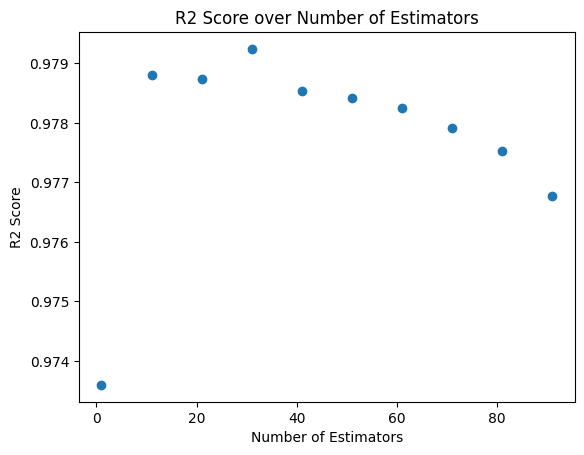

In [248]:
plt.scatter(x = estimator_range, y = [e[2] for e in estimator_res])
plt.xlabel("Number of Estimators")
plt.ylabel("R2 Score")
plt.title("R2 Score over Number of Estimators")
plt.show()

In [249]:
rate_range = np.arange(0.5, 1.60, 0.1)
rate_res = []
for r in rate_range:
    adr_current = AdaBoostRegressor(estimator = adr_feed, n_estimators = best_est[0], learning_rate = r)
    adr_current.fit(X_train, y_train)
    adr_current_preds = adr_current.predict(X_test)
    rate_res.append([r, np.sqrt(mean_squared_error(y_test, adr_current_preds)), r2_score(y_test, adr_current_preds)])
    

[0.7, 580.0315188003207, 0.9791251933711491]


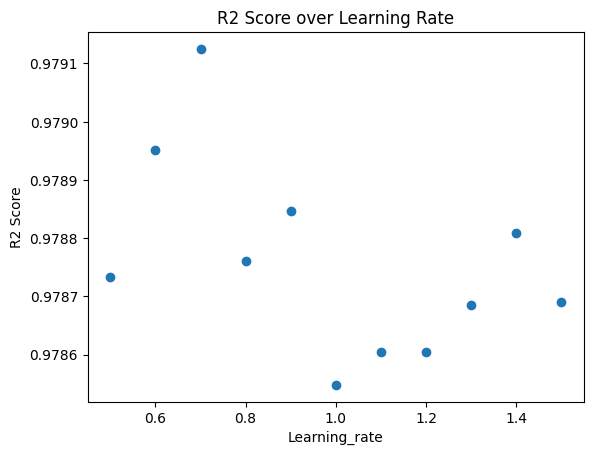

In [250]:
best_rate = max(rate_res, key= lambda r: r[2])
print(best_rate)

plt.scatter(x = rate_range, y = [e[2] for e in rate_res])
plt.xlabel("Learning_rate")
plt.ylabel("R2 Score")
plt.title("R2 Score over Learning Rate")
plt.show()

#### Hyperparameter Exploration Analysis & Combination Test

There is a point beyond which additional estimators provide little benefit. It appears that the default hyperparameter setting is not in fact optimal in this scenario. 

While the above plot of learning rates does exhibit a high degree of variance, generally it can be seen that lower learning rate values produce better results.

In [251]:
tuned_estimator_range = np.arange(best_est[0] - 3, best_est[0] + 4)
tuned_learning_range = np.arange(best_rate[0] - 0.2, best_rate[0] + 0.3, 0.05)
tuned_res = []

for e in tuned_estimator_range:
    for l in tuned_learning_range:
        adr_current = AdaBoostRegressor(estimator = adr_feed, n_estimators = e, learning_rate = l)
        adr_current.fit(X_train, y_train)
        adr_current_preds = adr_current.predict(X_test)
        tuned_res.append([e, l, np.sqrt(mean_squared_error(y_test, adr_current_preds)), r2_score(y_test, adr_current_preds)])


[28, 0.8499999999999999, 575.9298387791474, 0.9794193809739962]


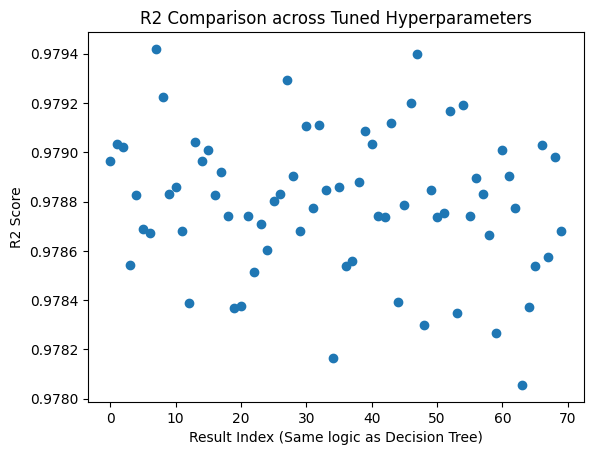

In [252]:
best_tune = max(tuned_res, key = lambda r: r[3])
print(best_tune)

plt.scatter(x = range(len(tuned_res)), y = [t[3] for t in tuned_res])
plt.xlabel("Result Index (Same logic as Decision Tree)")
plt.ylabel("R2 Score")
plt.title("R2 Comparison across Tuned Hyperparameters")
plt.show()

There is a great deal more variance in this plot relative to the Decision Tree, so no easily discernible trends can be observed. 

#### Tuned Results

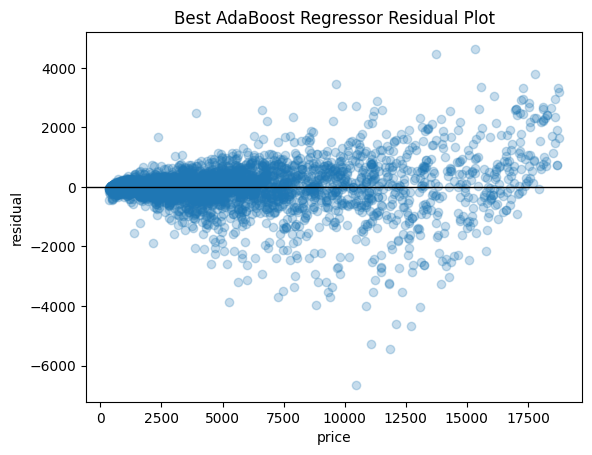

In [253]:
adr_best = AdaBoostRegressor(estimator = adr_feed, n_estimators = best_tune[0], learning_rate = best_tune[1])
adr_best.fit(X_train, y_train)
adr_best_preds = adr_best.predict(X_test)

best_adr_residuals = y_test - adr_best_preds

plt.scatter(y_test, best_dt_residuals, alpha = 0.25)
plt.axhline(0, c='black', linewidth = 1)
plt.title("Best AdaBoost Regressor Residual Plot")
plt.xlabel("price")
plt.ylabel("residual")
plt.show()


In [254]:
best_adr_rmse = np.sqrt(mean_squared_error(y_test, adr_best_preds))
best_adr_r2 = r2_score(y_test, adr_best_preds)
print("Best AdaBoost Regressor RMSE: ", best_adr_rmse)
print("Best AdaBoost Regressor R2 Score: ", best_adr_r2)

Best AdaBoost Regressor RMSE:  595.2093275037806
Best AdaBoost Regressor R2 Score:  0.9780184288575303


## Conclusion

It is finally time to compare all of the models against each other. 
First, to compare the two selected metrics of Root Mean Squared Error and R-Squared across the four models.

In [268]:
x = ['Multilinear Regression', 'KNN', 'Decision Tree', 'AdaBoost']
raw_rmse = [base_lr_rmse, knr_rmse, dtr_rmse, adr_rmse]
raw_r2 = [base_lr_r2, knr_r2, dtr_score, adr_r2]
y_rmse = [adjusted_lr_rmse, best_knr_rmse, best_dt_rmse, best_adr_rmse]
y_r2 = [adjusted_lr_r2, best_knr_r2, best_dt_r2, best_adr_r2]

results_df = pd.DataFrame({'model type': x, 'Raw RMSE': raw_rmse, 'Raw R2': raw_r2, 'Tuned RMSE': y_rmse, 'Tuned R2': y_r2})

results_df

,model type,Raw RMSE,Raw R2,Tuned RMSE,Tuned R2
0,Multilinear Regression,1108.066631,0.923818,1107.977792,0.923830
1,KNN,942.710032,0.944859,845.816662,0.955611
2,Decision Tree,765.378903,0.963653,620.470474,0.976113
3,AdaBoost,1444.491759,0.870536,595.209328,0.978018


The value in hyperparameter tuning is immediately apparent from the above table. While the AdaBoost Regressor was initially the worst, further tuning created the best regressor of the group, with the lowest RMSE and R-Squared numbers. Hyperparameter tuning continued to improve the performance of both K-Nearest Neighbors and the Decision Tree regressors, which use hyperparameters instead of parameters, unlike the Multilinear Regression model. 

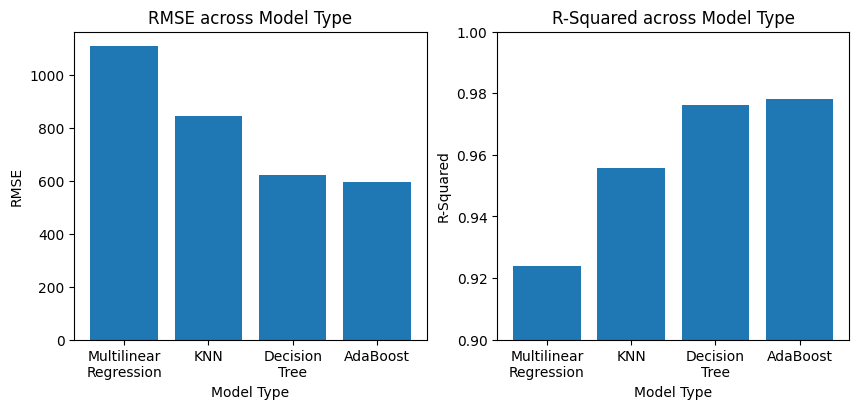

In [259]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
x = ['Multilinear\nRegression', 'KNN', 'Decision\nTree', 'AdaBoost']

ax[0].bar(x, y_rmse)
ax[0].set_xlabel("Model Type")
ax[0].set_ylabel("RMSE")
ax[0].set_title("RMSE across Model Type")

ax[1].bar(x, y_r2)
ax[1].set_ylim(0.9,1.0)
ax[1].set_xlabel("Model Type")
ax[1].set_ylabel("R-Squared")
ax[1].set_title("R-Squared across Model Type")

plt.show()

From the two plots seen above, the ordering of which models performed better is obvious. The AdaBoost Regressor outperformed all other models according to both metrics, and in descending order, the Decision Tree, K-Nearest Neighbor, and Multilinear Regressors, while still boasting high R-Squared values, failed to match the performance of the AdaBoost regressor. 

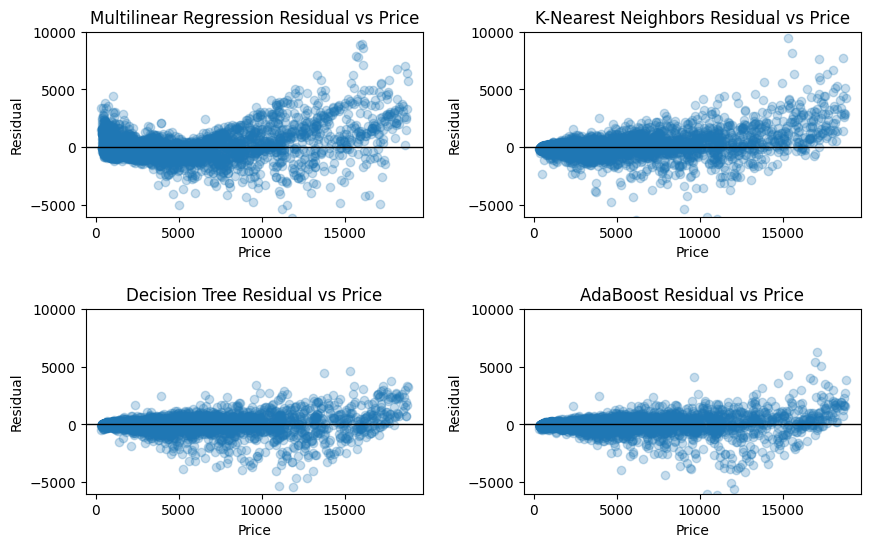

In [260]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0][0].scatter(y_test, adjusted_lr_residuals, alpha = 0.25)
ax[0][0].axhline(0, c='black', linewidth = 1)
ax[0][0].set_ylim(-6000, 10000)
ax[0][0].set_xlabel("Price")
ax[0][0].set_ylabel("Residual")
ax[0][0].set_title("Multilinear Regression Residual vs Price")

ax[0][1].scatter(y_test, best_knr_residuals, alpha = 0.25)
ax[0][1].axhline(0, c='black', linewidth = 1)
ax[0][1].set_ylim(-6000, 10000)
ax[0][1].set_xlabel("Price")
ax[0][1].set_ylabel("Residual")
ax[0][1].set_title("K-Nearest Neighbors Residual vs Price")

ax[1][0].scatter(y_test, best_dt_residuals, alpha = 0.25)
ax[1][0].axhline(0, c='black', linewidth = 1)
ax[1][0].set_ylim(-6000, 10000)
ax[1][0].set_xlabel("Price")
ax[1][0].set_ylabel("Residual")
ax[1][0].set_title("Decision Tree Residual vs Price")

ax[1][1].scatter(y_test, best_adr_residuals, alpha = 0.25)
ax[1][1].axhline(0, c='black', linewidth = 1)
ax[1][1].set_ylim(-6000, 10000)
ax[1][1].set_xlabel("Price")
ax[1][1].set_ylabel("Residual")
ax[1][1].set_title("AdaBoost Residual vs Price")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

plt.show()
# plt.scatter(y_test, best_dt_residuals, alpha = 0.25)
# plt.axhline(0, c='black', linewidth = 1)
# plt.title("Best AdaBoost Regressor Residual Plot")
# plt.xlabel("price")
# plt.ylabel("residual")

The same trend observed above in the bar plots can be seen here in the scatter plots of residuals vs price for each model: the AdaBoost regressor was most closely concentrated around 0, while the Decision Tree, K-Nearest Neighbors, and Multilinear Regression all have greater residual values. 

Another observation to make from the above plots is that the trend described in the introduction, where the skewed distribution of prices would affect the predictive power of each model as prices increased, can be seen here. For each model, the residuals at higher price levels are largest on average. 

That non-parametric models would excel to this degree is unexpected. Previous coursework has led me to the belief that feature-based approaches are ubiquitous because they perform better; however, this project has indicated that the broader picture of the Machine Learning landscape is more nuanced.

## Citations

[1] https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

[2] https://scikit-learn.org/stable/modules/tree.html#tree